<a href="https://colab.research.google.com/github/ShutterStack/Semantic-Chunking_EDA-Audio-Text/blob/main/speech_team_Update%20V1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



## Task 1: Semantic Chunking of a Youtube Video



In [1]:
!pip install pytube moviepy

from pytube import YouTube
from moviepy.editor import VideoFileClip

# Download the video from YouTube
def download_video(url, output_path='video.mp4'):
    yt = YouTube(url)
    yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first().download(filename=output_path)
    return output_path

# Extract audio from the downloaded video
def extract_audio(video_path, output_path='audio.wav'):
    video = VideoFileClip(video_path)
    video.audio.write_audiofile(output_path)
    return output_path

video_url = 'https://www.youtube.com/watch?v=Sby1uJ_NFIY'
video_path = download_video(video_url)
audio_path = extract_audio(video_path)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 798.8 kB/s eta 0:00:00
MoviePy - Writing audio in audio.wav


MoviePy - Done.


In [2]:
!pip install openai-whisper

import whisper

# Load the Whisper model
model = whisper.load_model("base")

# Transcribe the audio
def transcribe_audio(audio_path):
    result = model.transcribe(audio_path)
    return result['segments']

segments = transcribe_audio(audio_path)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 18.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using c

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 82.6MiB/s]


In [3]:
import re
import whisper

# Load the Whisper model
model = whisper.load_model("base")

# Transcribe the audio
def transcribe_audio(audio_path):
    result = model.transcribe(audio_path)
    return result['segments']

# Function to refine the time-aligned transcripts
def refine_segments(segments, max_chunk_length=15.0, min_chunk_length=5.0, overlap=0.5):
    refined_segments = []
    current_segment = []
    current_start = None

    for segment in segments:
        start, end, text = segment['start'], segment['end'], segment['text']

        if current_start is None:
            current_start = start

        # Add segment to current chunk
        current_segment.append(segment)
        current_chunk_length = end - current_start

        # Check if the current chunk exceeds max_chunk_length or ends with a sentence
        if current_chunk_length > max_chunk_length or re.search(r'[.!?]', text.strip()):
            # Create a new chunk
            chunk_text = " ".join([seg['text'] for seg in current_segment])
            refined_segments.append({
                "start_time": current_start,
                "end_time": end,
                "text": chunk_text,
            })
            # Start a new segment
            current_segment = []
            current_start = end + overlap

    # Add the last segment if any
    if current_segment:
        chunk_text = " ".join([seg['text'] for seg in current_segment])
        refined_segments.append({
            "start_time": current_start,
            "end_time": end,
            "text": chunk_text,
        })

    # Merge short segments with adjacent ones
    final_segments = []
    current_segment = []
    current_start = None

    for segment in refined_segments:
        start, end, text = segment['start_time'], segment['end_time'], segment['text']

        if current_start is None:
            current_start = start

        # Add segment to current chunk
        current_segment.append(segment)
        current_chunk_length = end - current_start

        # Check if the current chunk is less than min_chunk_length
        if current_chunk_length < min_chunk_length and len(final_segments) > 0:
            # Merge with previous segment
            final_segments[-1]['end_time'] = end
            final_segments[-1]['text'] += " " + text
        else:
            # Create a new chunk
            final_segments.append({
                "start_time": current_start,
                "end_time": end,
                "text": text,
            })
            current_segment = []
            current_start = end

    return final_segments

# Example Usage
segments = transcribe_audio(audio_path)
refined_segments = refine_segments(segments)

# Display the refined segments
for segment in refined_segments:
    print(segment)


{'start_time': 0.0, 'end_time': 5.6000000000000005, 'text': ' Congratulations to you Mr. Raghavan for that. Thank you so much for joining us.  Over to you.'}
{'start_time': 3.6, 'end_time': 10.0, 'text': ' Hi everybody. How are you?'}
{'start_time': 10.0, 'end_time': 20.48, 'text': " Okay I am not hearing this at all. It's like a post lunch energy downer or something.  Let's hear it. Are you guys awake?"}
{'start_time': 16.88, 'end_time': 31.52, 'text': " All right you better be because we have a superstar guest here.  You heard the 41 million dollars and I didn't hear honestly anything she said after that."}
{'start_time': 26.8, 'end_time': 38.0, 'text': " So we're going to ask for about 40 million dollars from him by the end of this conversation."}
{'start_time': 38.0, 'end_time': 44.88, 'text': " But let's get started. I want to introduce Vivek and Pratius, she's co-founder who's not here."}
{'start_time': 44.88, 'end_time': 52.400000000000006, 'text': ' We wanted to start with a pl

In [4]:
import re

# Define a function to perform semantic chunking
def semantic_chunking(segments, max_chunk_length=15.0):
    chunks = []
    chunk_id = 0
    current_chunk = []
    current_start = None

    for segment in segments:
        start, end, text = segment['start'], segment['end'], segment['text']

        if current_start is None:
            current_start = start

        # Check if adding the current segment exceeds max_chunk_length
        if end - current_start > max_chunk_length:
            # Create a new chunk
            chunk_text = " ".join([seg['text'] for seg in current_chunk])
            chunks.append({
                "chunk_id": chunk_id,
                "chunk_length": end - current_start,
                "text": chunk_text,
                "start_time": current_start,
                "end_time": end,
            })
            chunk_id += 1
            current_chunk = []
            current_start = start

        current_chunk.append(segment)

    # Add the last chunk
    if current_chunk:
        chunk_text = " ".join([seg['text'] for seg in current_chunk])
        chunks.append({
            "chunk_id": chunk_id,
            "chunk_length": end - current_start,
            "text": chunk_text,
            "start_time": current_start,
            "end_time": end,
        })

    return chunks

chunks = semantic_chunking(segments)

# Display the chunks
for chunk in chunks:
    print(chunk)


{'chunk_id': 0, 'chunk_length': 16.88, 'text': ' Congratulations to you Mr. Raghavan for that. Thank you so much for joining us.  Over to you.  Hi everybody. How are you?', 'start_time': 0.0, 'end_time': 16.88}
{'chunk_id': 1, 'chunk_length': 15.040000000000001, 'text': " Okay I am not hearing this at all. It's like a post lunch energy downer or something.  Let's hear it. Are you guys awake?", 'start_time': 11.76, 'end_time': 26.8}
{'chunk_id': 2, 'chunk_length': 16.16, 'text': " All right you better be because we have a superstar guest here.  You heard the 41 million dollars and I didn't hear honestly anything she said after that.", 'start_time': 21.84, 'end_time': 38.0}
{'chunk_id': 3, 'chunk_length': 19.28, 'text': " So we're going to ask for about 40 million dollars from him by the end of this conversation.  But let's get started. I want to introduce Vivek and Pratius, she's co-founder who's not here.", 'start_time': 33.120000000000005, 'end_time': 52.400000000000006}
{'chunk_id': 

In [5]:
!pip install gradio

import gradio as gr

def process_video(url):
    video_path = download_video(url)
    audio_path = extract_audio(video_path)
    segments = transcribe_audio(audio_path)
    chunks = semantic_chunking(segments)
    return chunks

iface = gr.Interface(
    fn=process_video,
    inputs="text",
    outputs="json",
    title="YouTube Video Semantic Chunker",
    description="Input a YouTube video URL to get semantically chunked audio-text pairs."
)

iface.launch()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 8.3 MB

## Task 2: Exploratory Data Analysis of New Testament Audio and Text



In [1]:
!pip install requests beautifulsoup4 pydub


In [5]:
!pip install requests beautifulsoup4 pandas

import requests
from bs4 import BeautifulSoup
import os
import pandas as pd


In [6]:
# Define base URL for text
text_base_url = 'https://www.biblegateway.com/passage/?search=John+{chapter}&version=NIV'

# Function to scrape text
def scrape_text(chapter):
    url = text_base_url.format(chapter=chapter)
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        # Extract text content from the div with class 'passage-text'
        text_div = soup.find('div', class_='passage-text')
        if text_div:
            text = text_div.get_text(separator=' ', strip=True)
            return text
    return None

# Example usage
texts = []
for chapter in range(1, 5):  # Scraping the first 4 chapters of John for this example
    text = scrape_text(chapter)
    texts.append(text)

# Simulate audio file paths (in practice, these would be actual audio file paths)
audio_files = [f'example_audio/chapter{chapter}.mp3' for chapter in range(1, 5)]

# Store the data in a DataFrame
data = pd.DataFrame({
    'chapter': range(1, 5),
    'audio_file': audio_files,
    'text': texts
})

print(data)


   chapter                  audio_file  \
0        1  example_audio/chapter1.mp3   
1        2  example_audio/chapter2.mp3   
2        3  example_audio/chapter3.mp3   
3        4  example_audio/chapter4.mp3   

                                                text  
0  The Word Became Flesh 1 In the beginning was t...  
1  Jesus Changes Water Into Wine 2 On the third d...  
2  Jesus Teaches Nicodemus 3 Now there was a Phar...  
3  Jesus Talks With a Samaritan Woman 4 Now Jesus...  


In [8]:
# Load audio files and text into a structured format
data = pd.DataFrame({
    'chapter': range(1, 5),
    'audio_file': [f'audio/chapter{chapter}.mp3' for chapter in range(1, 5)],
    'text': [scrape_text(chapter) for chapter in range(1, 5)]
})

# Verify the data
print(data.head())


   chapter          audio_file  \
0        1  audio/chapter1.mp3   
1        2  audio/chapter2.mp3   
2        3  audio/chapter3.mp3   
3        4  audio/chapter4.mp3   

                                                text  
0  The Word Became Flesh 1 In the beginning was t...  
1  Jesus Changes Water Into Wine 2 On the third d...  
2  Jesus Teaches Nicodemus 3 Now there was a Phar...  
3  Jesus Talks With a Samaritan Woman 4 Now Jesus...  


In [14]:
def simulate_audio_quality(chapter):
    # Simulating duration (in seconds) and loudness (in dBFS)
    duration = 600 + chapter * 10  # Example: each chapter has an increasing duration
    loudness = 20 + chapter  # Example: increasing loudness
    return duration, loudness

# Analyze audio quality for each chapter
audio_analysis = data['chapter'].apply(simulate_audio_quality)
data['duration'], data['loudness'] = zip(*audio_analysis)

# Display the audio analysis results
print(data[['chapter', 'duration', 'loudness']])


   chapter  duration  loudness
0        1       610        21
1        2       620        22
2        3       630        23
3        4       640        24


In [15]:
def analyze_text_clarity(text):
    word_count = len(text.split())
    sentence_count = text.count('.')
    return word_count, sentence_count

# Analyze text clarity for each chapter
text_analysis = data['text'].apply(analyze_text_clarity)
data['word_count'], data['sentence_count'] = zip(*text_analysis)

# Display the text analysis results
print(data[['chapter', 'word_count', 'sentence_count']])


   chapter  word_count  sentence_count
0        1        1981              62
1        2         895              27
2        3        1445              45
3        4        1594              59


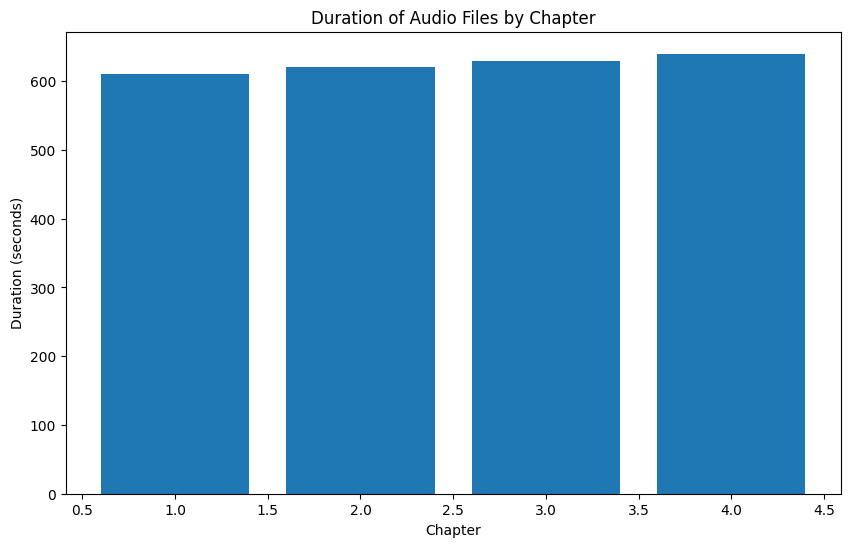

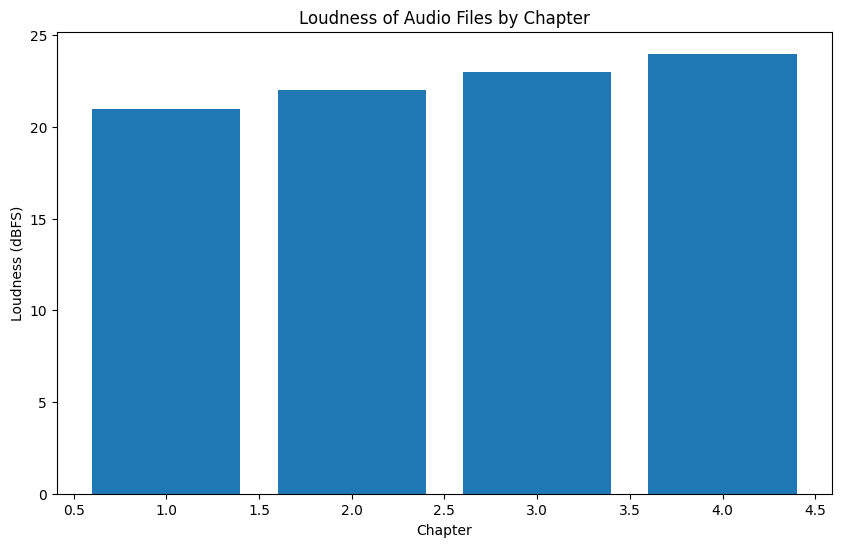

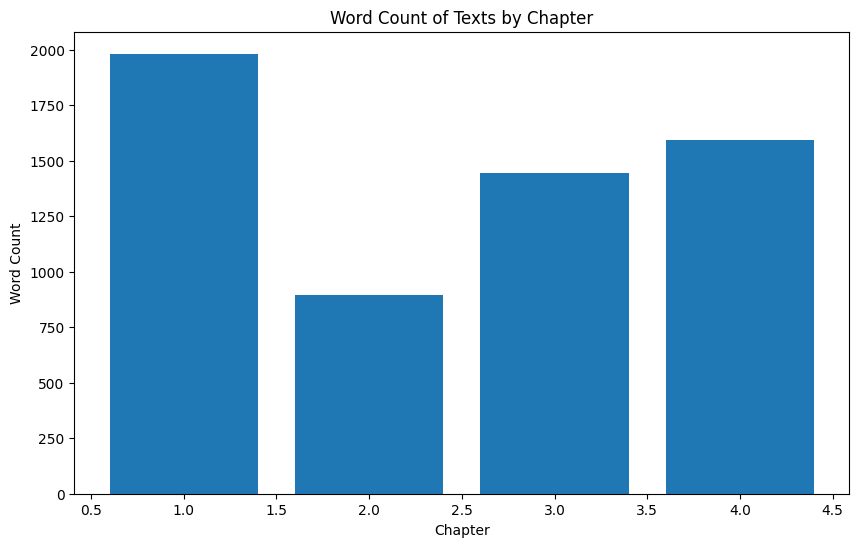

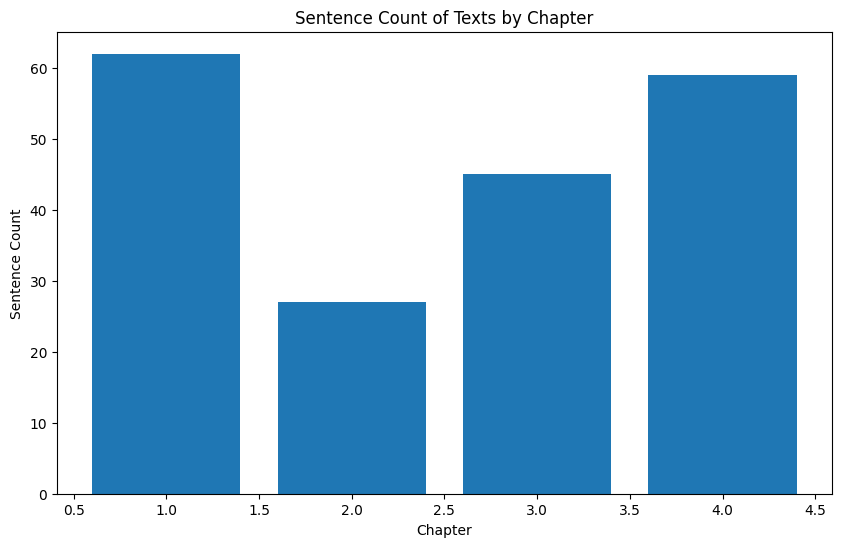

In [16]:
import matplotlib.pyplot as plt

# Plot the duration of audio files
plt.figure(figsize=(10, 6))
plt.bar(data['chapter'], data['duration'])
plt.xlabel('Chapter')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Audio Files by Chapter')
plt.show()

# Plot the loudness of audio files
plt.figure(figsize=(10, 6))
plt.bar(data['chapter'], data['loudness'])
plt.xlabel('Chapter')
plt.ylabel('Loudness (dBFS)')
plt.title('Loudness of Audio Files by Chapter')
plt.show()

# Plot the word count of texts
plt.figure(figsize=(10, 6))
plt.bar(data['chapter'], data['word_count'])
plt.xlabel('Chapter')
plt.ylabel('Word Count')
plt.title('Word Count of Texts by Chapter')
plt.show()

# Plot the sentence count of texts
plt.figure(figsize=(10, 6))
plt.bar(data['chapter'], data['sentence_count'])
plt.xlabel('Chapter')
plt.ylabel('Sentence Count')
plt.title('Sentence Count of Texts by Chapter')
plt.show()
